In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import numpy as np

In [6]:
# Replace the keys in this dicitonnary to match the names of the PREVis subscales columns in your data.set
# Each of these 4 columns should contain the average of the subscale's ratings for each participant (row).
colors = {
    "Understand" : ['#4ba1bc','#829599'],
    "Layout" : ['#839e49', '#969b86'],
    "DataRead" : ['#a87c9f', '#a396a0'],
    "DataFeat" : ['#e08095', '#c6b6ba']
}

# Repeated measures

In [7]:
#load data
#columns are: participants ID ("PID"), condition ("Visualization"), and each subscale ("Understand","Layout","DataRead","DataFeat")
#important: in repeated measures, each participant x condition is a row. The PIDs are repeated for each condition.
PREVis_df = pd.read_csv('PREVis_ratings.csv', index_col='PID')

In [10]:
#### point estimate plots

def make_pointplot(d, scale, condition, colordict=colors, outfile=None):
    """
    Plots point estimates and CIs across conditions.
    The 95% and 99% bootstrap confidence intervals are estimated by seaborn (see https://seaborn.pydata.org/tutorial/error_bars.html).

    Parameters:
    - df: DataFrame containing the data.
    - scale: The column name in df containing means for on of PREVis subscale.
    - condition: The column name in df representing different measures points (repeated measures, or different within-participants condition).
    - colordict: A dictionary mapping the scales names to colors.
    - outfile: file path where the plot will be saved, optional.
    """

    # code to create a point estimate plot with 95% AND 99% CI
    # adujst the size depending on how many conditions there are
    fig, ax = plt.subplots(figsize=(6, 1))

    sns.pointplot(
        data=d,
        x=scale,
        y=condition,
        color=colordict[scale][0],
        linestyles="",
        linewidth=2,
        markersize=4,
        marker="D",
        errorbar=('ci', 95), #this will draw the 95% bar
        ax=ax)
    
    #second error bar (99%)
    sns.pointplot(
        data=d,
        x=scale,
        y=condition,
        errorbar=('ci', 99),
        color=colordict[scale][0],
        linestyles="",
        linewidth=0.5,
        markersize=0,
        ax=ax)

    #background grey color
    ax.set_facecolor((0.9,0.9,0.9))

    ax.set_xlim(left=1, right=7)
    ax.set_xlabel(f'{scale} average ratings with 95% and 99% CI')

    # Manually plot vertical lines following x-axis ticks
    for x_tick in ax.get_xticks()[0:]: #ignoring the first tick
        ax.axvline(x_tick, color=((0,0,0,0.1)), linewidth=1, zorder=5)

    # y axis parameters
    ax.tick_params(axis='y', width=0) # remove ticks
    ax.grid(axis='y', linewidth=36, color='white', alpha=0.95, zorder=0)

    ax.legend(title='', loc='upper left', edgecolor='white')

    sns.despine(top=True, right=True) #removing the frame

    plt.show(fig)
    if outfile:
        fig.savefig(outfile, bbox_inches='tight')

#### repeated measures differences plot

def make_manual_diff(df, scale, condition, colordict = colors, outfile=None):
    """
    Plots within-participant differences between two conditions.
    You should adapt this code if you have more that two within-participant conditions.

    The 95% and 99% bootstrap confidence intervals are estimated by seaborn (see https://seaborn.pydata.org/tutorial/error_bars.html).

    Parameters:
    - df: DataFrame containing the data.
    - scale: The column name in df containing means for on of PREVis subscale.
    - condition: The column name in df representing different measures points (repeated measures, or different within-participants condition).
    - colordict: A dictionary mapping the scales names to colors.
    - outfile: file path where the plot will be saved, optional.
    """

    # we get the name of the two conditions (you will need to adapt this if you have more than two conditions)
    if len(list(df[condition].unique())) > 2:
        raise ValueError("This function is only for two conditions")
    
    cat1 = list(df[condition].unique())[1]
    df1 = df[df[condition] == cat1]
    cat2 = list(df[condition].unique())[0]
    df2 = df[df[condition] == cat2]

    test_name = f'{scale}: {cat1}-{cat2} difference'

    manual_diff= {}
    for PID in df1.index:
        manual_diff[PID] = df1.loc[PID, scale] - df2.loc[PID, scale]
    
    manual_diff_df = pd.DataFrame.from_dict(manual_diff, orient='index', columns=[test_name])
    

    #plot and first error bar

    fig, ax = plt.subplots(figsize=(6, 1))
    plot = sns.pointplot(
        data=manual_diff_df, x=test_name, #y=group, hue=group,
        #palette=palette,        
        errorbar=('ci', 95), 
        capsize=0, dodge=0,
        linestyle="none", linewidth=2,
        marker="D", markersize=4,
        color=colordict[scale][0],
        ax=ax  # Plot on the i-th subplot
    )

    color = plot.lines[0].get_color()

    # Second error bar
    sns.pointplot(
        data=manual_diff_df, x=test_name,
        errorbar=('ci', 99), 
        capsize=0, dodge=0,
        linestyle="none", linewidth=0.5,
        marker="D", markersize=0,
        color=colordict[scale][0],
        ax=ax  # Plot on the i-th subplot
    )
    
    # ax.set_title(f'Measure: {labels[column] if labels and column in labels else column}')
    ax.set_xlabel(f'{test_name} with 95% and 99 % CI', labelpad=4)  # Change x-axis label

    manual_diff_value = manual_diff_df[test_name].mean()
    match manual_diff_value:
        case manual_diff_value if manual_diff_value > 0: # if the difference is positive, we plot to the right
            x0 = 0 # index of min value in tuple
            x1 = 1 # index of max value in tuple
            m = 1 # coeff
            print('positive')

        case manual_diff_value if manual_diff_value < 0: # if the difference is positive, we plot to the left
            m = -1
            x0 = 1
            x1 = 0
            print('negative')

    xlims=(-1, 2)
    
    
    min_x = xlims[x0]*m 
    max_x = xlims[x1]*m
    ax.set_xlim(min_x, max_x)

    # x axis modifications
    # Add a grid 
    # Set x-ticks to include min and max values
    x_min, x_max = ax.get_xlim()
    ax.set_xticks(np.arange(np.floor(x_min), np.ceil(x_max)+1))
    ax.xaxis.grid(True, color='#E0E0E0', linewidth=0.5)
    # set ticks to int
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    

    # Draw a vertical line at 0
    ax.axvline(0, color=(0,0,0,0.8), linewidth=0.5)
    
    # remove plot outlines
    sns.despine()
    # Remove y-axis line
    ax.spines['left'].set_visible(False)
    
    # Remove y labels and ticks
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_yticks([])

        # Remove plot outlines
    sns.despine(left=True)

    # Remove y-axis line
    ax.yaxis.set_ticks([])

    if outfile:
        fig.savefig(outfile, bbox_inches='tight')


#### scatterplot

def plot_scatter(df, scale, condition, colordict, outfile):
    """
    Plots a scatterplot using the first unique value in the visualization column for the x-axis
    and the second unique value for the y-axis. 
    
    You should adapt this code if you have more that two within-participant conditions.

    Parameters:
    - df: DataFrame containing the data.
    - scale: The column name in df containing means for on of PREVis subscale.
    - condition: The column name in df representing different measures points (repeated measures, or different within-participants condition).
    - colordict: A dictionary mapping the scales names to colors.
    - outfile: file path where the plot will be saved, optional.
    """

    # Extract the two unique values
    unique_values = df[condition].unique()
    if len(unique_values) != 2:
        raise ValueError("Measures column must have exactly 2 unique values")
    
    # Correctly filter the DataFrame for each unique value and select the scale column
    x_values = df[df[condition] == unique_values[0]][scale]
    y_values = df[df[condition] == unique_values[1]][scale]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.regplot(
        data=df,
        x=x_values,
        y=y_values,
        color=colordict[scale][0],
        ci=99,
         scatter_kws={"s": 10},
        ax=ax)
    
    # Set figure aesthetics
    
    ax.set_xlim(left=0.8, right=7.2)
    ax.set_ylim(bottom=0.8, top=7.2)
    ax.set_xlabel(f'{unique_values[0]}{scale} ratings')
    ax.set_ylabel(f'{unique_values[1]}{scale} ratings')
    sns.despine(left=True, top=True, right=True)
    
    # Show and save the plot
    plt.show()
    if outfile:
        fig.savefig(outfile, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


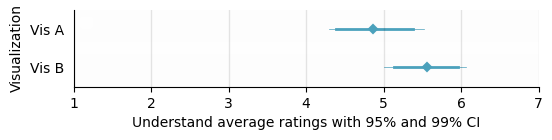

positive


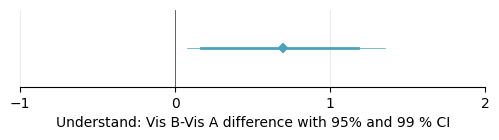

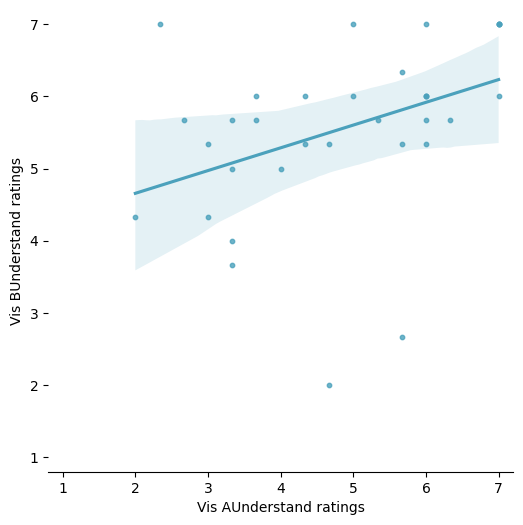

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


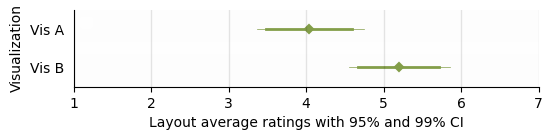

positive


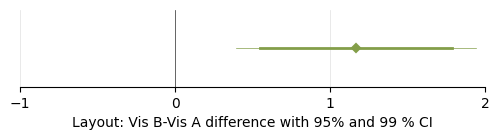

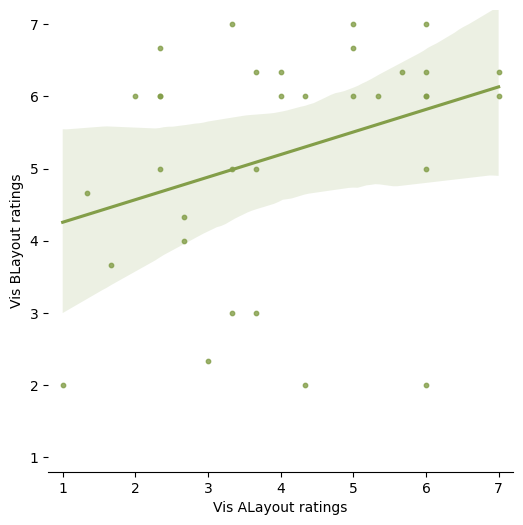

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


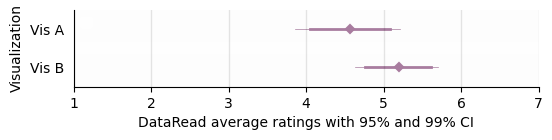

positive


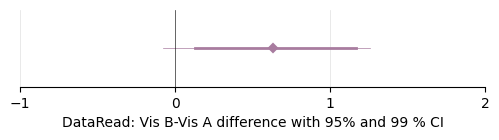

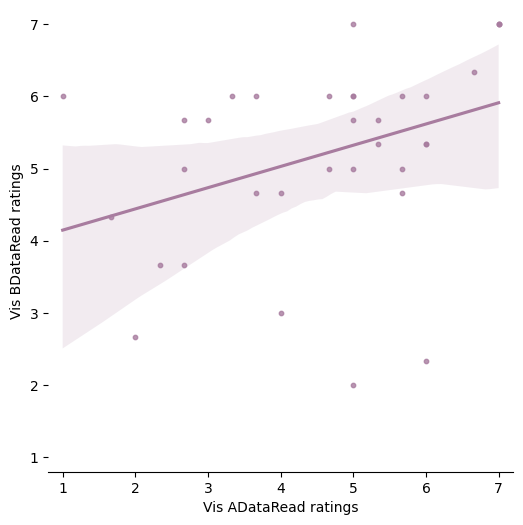

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


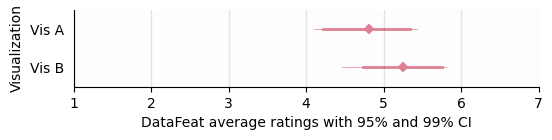

positive


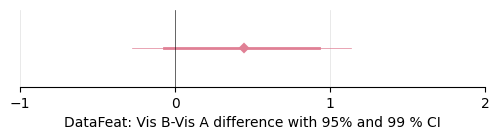

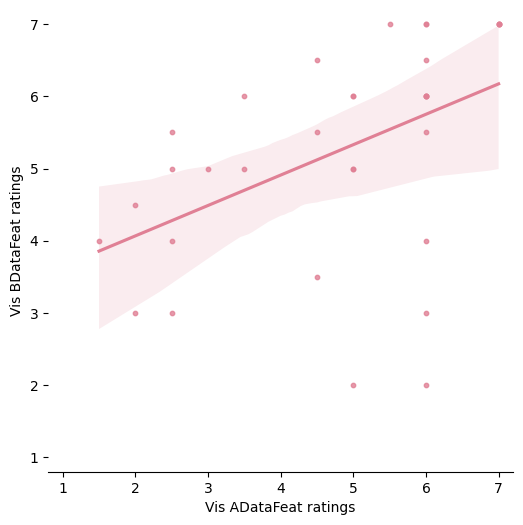

In [11]:
condition_col = 'Visualization'
for scale in colors.keys():
    d = PREVis_df[[scale, condition_col]]

    make_pointplot(d, scale, condition_col, colordict = colors, outfile=f"repeated_measures_{scale}.pdf")
    make_manual_diff(d, scale, condition_col, colordict = colors, outfile=f"repeated_measures_{scale}_diff.pdf")

    # scatter plot to ensure correlations are positive among repeated measures
    plot_scatter(d, scale, condition_col, colordict = colors, outfile=f'repeated_measures_{scale}_scatter.pdf')

# Individual plots

In [38]:
def plot_individual_scale_scores(df, scale, colordict = colors, outfile=None):

    """
    Plots a scatterplot of individual participants' scores for a given scale in a single visualization.

    Parameters:
    - df: DataFrame containing the data.
    - scale: The column name in df containing means for on of PREVis subscale.
    - colordict: A dictionary mapping the scales names to colors.
    - outfile: file path where the plot will be saved, optional.
    """
    
    # you can adapt the figure depending on the number of participants.

    fig, ax = plt.subplots(figsize=(6, 1.5))

    plt.xlim(0.8, 7.2) 

    # Set x-axis tick positions and labels
    tick_positions = [1, 2, 3, 4, 5, 6, 7]
    tick_labels = ['Strongly\ndisagree', 'Disagree', 'Slightly\ndisagree', 'Neutral', 'Slightly\nagree', 'Agree', 'Strongly\nagree']  # Customize these labels as needed
    plt.xticks(tick_positions, tick_labels)

    # x-axis grid lines
    ax.xaxis.grid(True, color=(0.878, 0.878, 0.878, 0.5), linewidth=0.5)
    ax.set_axisbelow(True)

    sns.scatterplot(data=df,
                    x=scale,
                    y='PID',
                    color=colordict[scale][0],
                    s=50,
                    zorder=15)  # s is the size of the dots

    # Disable y-axis tick marks
    ax.tick_params(axis='y', length=0)  
    
    # Draw horizontal dash lines from y-axis to each dot
    for _, row in df.iterrows():
        plt.hlines(y=row['PID'],
                xmin=0,
                xmax=row[scale],
                colors=colordict[scale][1],
                linestyles='--',
                linewidth=0.5,
                zorder=1)

    sns.despine(left=True, bottom=True, top=True, right=True) #removing the frame

    plt.xlabel('')
    plt.ylabel('')
    # plt.title(f'PREVis {scale} ratings per Participant')
    # plt.title(f'{scale} ratings', color=colors[scale][0], fontweight='bold')
    plt.title(f'{scale} ratings')
    plt.show()
    
    if outfile:
        fig.savefig(outfile, bbox_inches='tight')

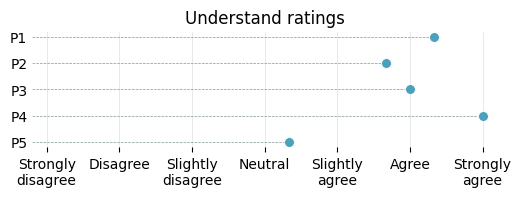

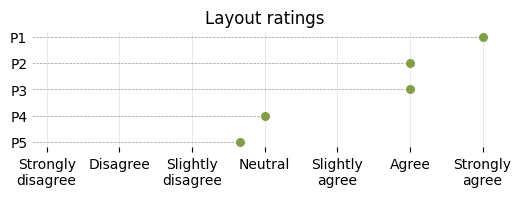

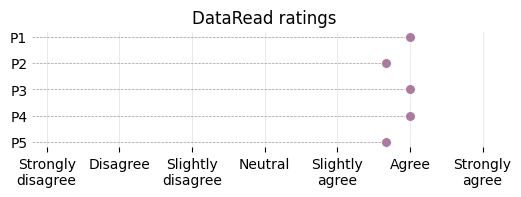

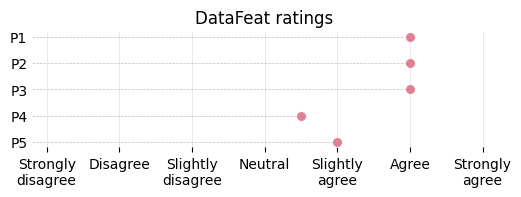

In [39]:
df = pd.read_csv('PREVis_1vis_5participants.csv')
for scale in colors.keys():
    this_scale_df = df[['PID', scale]]
    plot_individual_scale_scores(this_scale_df, scale, colordict = colors, outfile=f'Individual_scores_{scale}.pdf')